# EIS Collection Graphs

Plot summary figures from the latest run outputs.

In [1]:
from pathlib import Path
import re

import pandas as pd
import matplotlib.pyplot as plt


def resolve_processed_base() -> Path:
    cwd = Path.cwd().resolve()
    candidates = [
        cwd / "data" / "processed",
        cwd / "processed",
    ]
    for parent in [cwd, *cwd.parents]:
        candidates.append(parent / "data" / "processed")
    for candidate in candidates:
        if candidate.exists():
            return candidate
    raise FileNotFoundError("Could not locate data/processed directory from cwd")


def extract_run_id(path: Path) -> int | None:
    match = re.search(r"run_(\d+)_", path.name)
    if not match:
        return None
    return int(match.group(1))


def latest_run_id(path: Path) -> int | None:
    run_ids = [extract_run_id(p) for p in path.glob("*.parquet")]
    run_ids = [rid for rid in run_ids if rid is not None]
    return max(run_ids) if run_ids else None


def read_run_parquets(path: Path, run_id: int | None) -> pd.DataFrame:
    if run_id is None:
        files = list(path.glob("*.parquet"))
    else:
        files = list(path.glob(f"*run_{run_id}_*.parquet"))
    if not files:
        return pd.DataFrame()
    frames = [pd.read_parquet(file) for file in sorted(files)]
    return pd.concat(frames, ignore_index=True)


base = resolve_processed_base()
run_id = latest_run_id(base / "attributes")
print("Using processed base:", base)
print("Latest run_id:", run_id)

attributes = read_run_parquets(base / "attributes", run_id)
print("attributes rows", len(attributes))

Matplotlib is building the font cache; this may take a moment.


Using processed base: /Users/home/Work/10-edu/data-science/thesis/code/masters-thesis-dev/data/processed
Latest run_id: 18
attributes rows 4886


In [4]:
plt.rcParams['font.size'] = 12
plt.rcParams['figure.figsize'] = 8, 5
plt.rcParams['savefig.format'] = 'pdf'

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

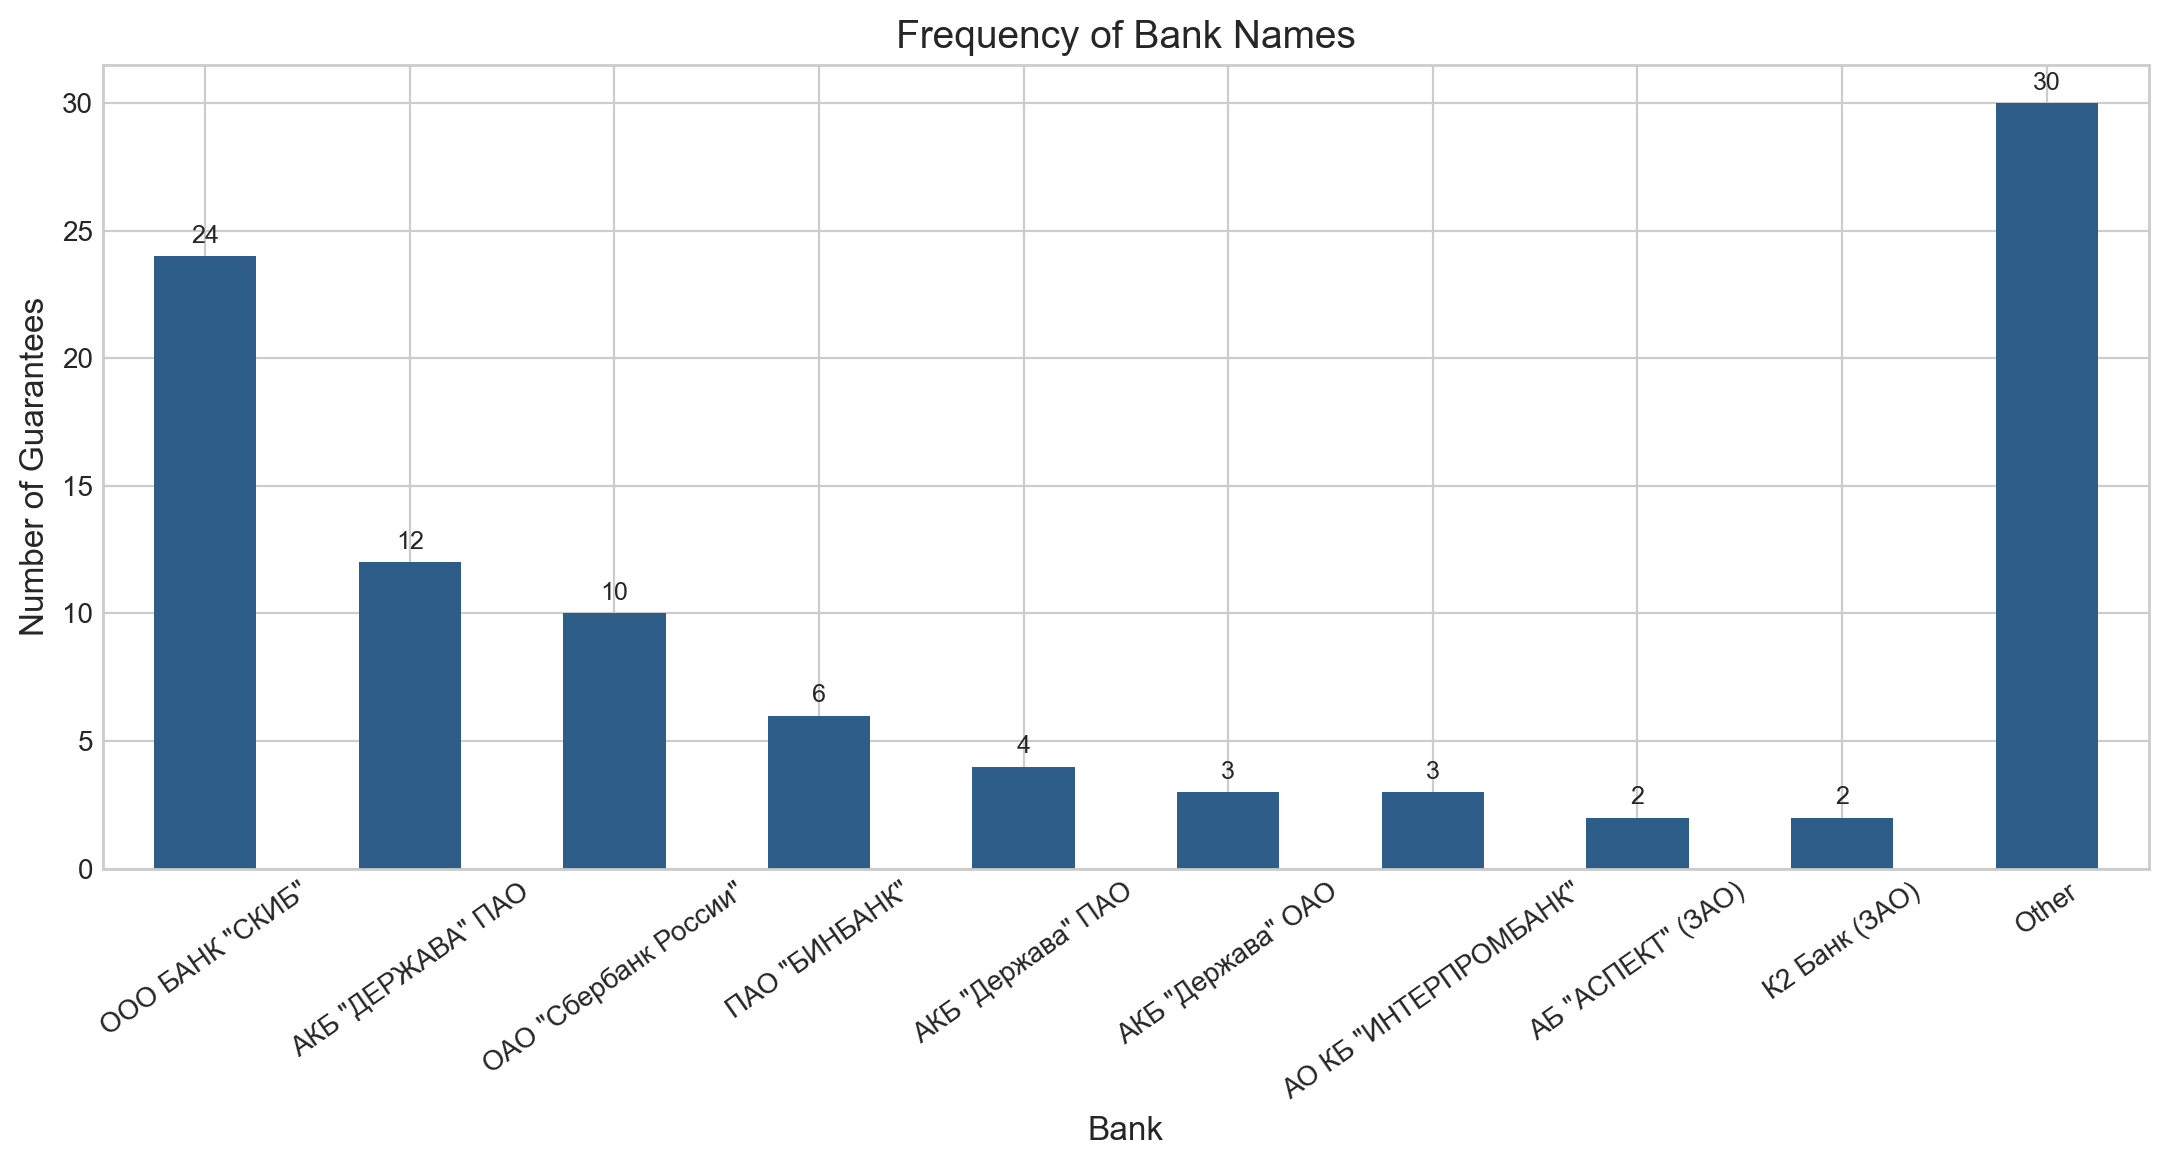

In [8]:
if attributes.empty:
    raise RuntimeError("Attributes table is empty for the latest run.")

bank_names = (
    attributes.loc[
        attributes["field_name"].eq("Сокращенное наименование банка"),
        "field_value",
    ]
    .dropna()
    .astype(str)
    .str.strip()
)

counts = bank_names.value_counts()
if counts.empty:
    raise RuntimeError("No bank short names found in attributes table.")

head = counts.head(9)
tail_total = counts.iloc[9:].sum()

plot_series = head.copy()
if tail_total > 0:
    plot_series.loc["Other"] = tail_total

plt.style.use("seaborn-v0_8-whitegrid")
fig, ax = plt.subplots(figsize=(11, 6))
plot_series.plot(kind="bar", ax=ax, color="#2F5D8A")

ax.set_title("Frequency of Bank Names", fontsize=14)
ax.set_xlabel("Bank", fontsize=12)
ax.set_ylabel("Number of Guarantees", fontsize=12)
ax.tick_params(axis="x", labelrotation=35, labelsize=10)
ax.tick_params(axis="y", labelsize=10)

for container in ax.containers:
    ax.bar_label(container, padding=3, fontsize=9)

plt.tight_layout()
# Save the figure as a PDF file
plt.savefig("my_plot.pdf")
plt.show()